In [1]:
# main_pipeline.py

from utils.mission_metadata import MissionDB
from utils.direction import direction_zone
from utils.rover_path import rover_path_direction
from utils.objects import *
from utils.json_builder import build_output
from models.inference import run_model
#from utils.visualization_utils import visualize_prediction
import json
import cv2

In [2]:
# ---------------------------
# LOAD MODEL (Roboflow)
# ---------------------------
def load_model(api_key, workspace, project, version):
    from roboflow import Roboflow
    rf = Roboflow(api_key=api_key)
    proj = rf.workspace(workspace).project(project)
    model = proj.version(version).model
    return model


In [3]:


def process_image(image,outputs, mission_name):
    mission = MissionDB().get(mission_name)
    mpp = mission["mpp"]
    H, W = image.shape[:2]

    features = {
        "craters": {},
        "rocks": {},
        "boulders": {},
        "rocky_regions": {},
        "artifacts": {},
        "artifact_path": {},
        "confidence_score": []
    }

    crater_i = rock_i = boulder_i = region_i = art_i = path_i = 1

    for obj in outputs['predictions']:
        poly = [(p['x'], p['y']) for p in obj['points']]
        clse = obj["class"]
        conf = obj["confidence"]

        features["confidence_score"].append(conf)

        if clse == "crater":
            d = process_crater(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["craters"][crater_i] = d
            crater_i += 1

        elif clse == "rock":
            d = process_rock(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["rocks"][rock_i] = d
            rock_i += 1

        elif clse == "boulder":
            d = process_boulder(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["boulders"][boulder_i] = d
            boulder_i += 1

        elif clse == "rocky_region":
            d = process_rocky_region(poly, mpp)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["rocky_regions"][region_i] = d
            region_i += 1

        elif clse == "artifact":
            d = process_artifact(poly)
            d["direction_zone"] = direction_zone(d["location"]["x"], d["location"]["y"], W, H)
            features["artifacts"][art_i] = d
            art_i += 1

        elif clse == "rover path":
            directions = rover_path_direction(poly)
            features["artifact_path"][path_i] = {
                "direction_sequence": directions,
                "start": directions[0],
                "end": directions[-1]
            }
            path_i += 1

    return build_output(features)

In [4]:
from tkinter import Tk, filedialog

def pick_image():
    Tk().withdraw()  # hide main window
    file_path = filedialog.askopenfilename(
        title="Select an Image",
        filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp *.tif *.tiff")]
    )
    return file_path


In [5]:

image_path = pick_image()
img = cv2.imread(image_path)
print("Selected image:", image_path)

Selected image: D:/Phase1_Dataset/TCAM/C3_TCAM_4_2C_120.png


In [6]:
model = load_model(
        api_key="McrhzGgUVuaQbO2a1BX6",
        workspace="chandai",
        project="lunar-scene-analysis-fejkh",
        version=5
    )

loading Roboflow workspace...
loading Roboflow project...


In [7]:
# Run prediction
output = model.predict(image_path, confidence=40).json()

# Print results
print(output)

{'predictions': [{'x': 1689.6542358398438, 'y': 348.0196075439453, 'width': 661.1497802734375, 'height': 164.40438842773438, 'confidence': 0.873393714427948, 'class': 'rock', 'points': [{'x': 1650.0, 'y': 271.0}, {'x': 1649.0, 'y': 272.0}, {'x': 1633.0, 'y': 272.0}, {'x': 1632.0, 'y': 273.0}, {'x': 1619.0, 'y': 273.0}, {'x': 1618.0, 'y': 274.0}, {'x': 1607.0, 'y': 274.0}, {'x': 1606.0, 'y': 275.0}, {'x': 1597.0, 'y': 275.0}, {'x': 1596.0, 'y': 276.0}, {'x': 1589.0, 'y': 276.0}, {'x': 1588.0, 'y': 277.0}, {'x': 1582.0, 'y': 277.0}, {'x': 1581.0, 'y': 278.0}, {'x': 1573.0, 'y': 278.0}, {'x': 1572.0, 'y': 279.0}, {'x': 1564.0, 'y': 279.0}, {'x': 1563.0, 'y': 280.0}, {'x': 1558.0, 'y': 280.0}, {'x': 1557.0, 'y': 281.0}, {'x': 1543.0, 'y': 281.0}, {'x': 1542.0, 'y': 280.0}, {'x': 1535.0, 'y': 280.0}, {'x': 1534.0, 'y': 281.0}, {'x': 1531.0, 'y': 281.0}, {'x': 1530.0, 'y': 282.0}, {'x': 1527.0, 'y': 282.0}, {'x': 1526.0, 'y': 283.0}, {'x': 1523.0, 'y': 283.0}, {'x': 1522.0, 'y': 284.0}, {'x'

In [8]:
# ------------------------
# USAGE
# ------------------------

db = MissionDB()

# Chang'e 3 mission data
change3_data = [
    "Chang3",         # mission_name
    0.5,              # meters_per_pixel
    15,               # camera_angle_deg
    1024,             # camera_resolution_w
    1024,             # camera_resolution_h
    45,               # camera_fov_deg
    1.5,              # rover_height_m
    "Lunar lander with Yutu rover, landed Dec 2013. Camera specs approximate."  # notes
]

# Add mission to CSV
db.add_mission(change3_data)

In [9]:
img = cv2.imread(image_path)
results = process_image(
        img,
        output,
        mission_name="Chang3"
    )

In [10]:
# # Visualize predictions

from PIL import Image, ImageDraw
import cv2
import numpy as np
img = Image.open(image_path)
draw = ImageDraw.Draw(img)

for obj in output['predictions']:
   
        points = [(p['x'], p['y']) for p in obj['points']]
        draw.polygon(points, outline="red")
       
   
img.show()
print(img)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=2352x1728 at 0x1A6017E1450>


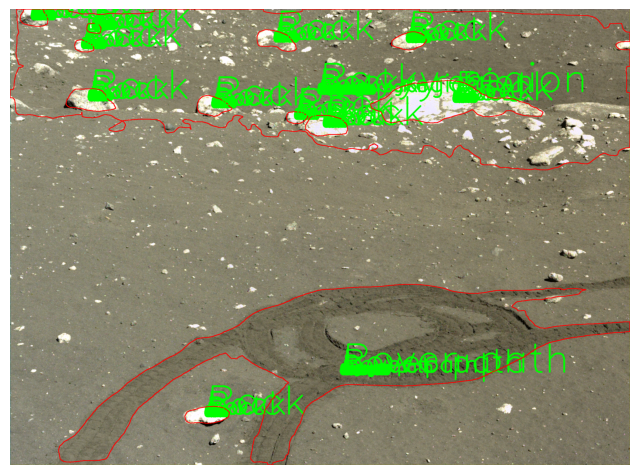

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


for obj in output['predictions']:
        class_name = obj['class'].capitalize()
        polygon_points = [(p['x'], p['y']) for p in obj['points']]
    
    
    # Optional visualization
        img=np.array(img)
        img_2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.polylines(img, [np.array(polygon_points, np.int32)], isClosed=True, color=(255,0,0), thickness=2)
        cv2.putText(img, class_name, (int(obj['x']), int(obj['y']-5)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3)
        
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [12]:
print("\nSingle Output:")
print(json.dumps(results, indent=4))


Single Output:
{
    "image_features": {
        "craters": {},
        "rocks": {
            "1": {
                "size_m": 327.3912033027155,
                "location": {
                    "x": 1649.395682141623,
                    "y": 355.8234026400215
                },
                "direction_zone": "NE"
            },
            "2": {
                "size_m": 94.92760399378044,
                "location": {
                    "x": 302.3228780979132,
                    "y": 345.65239534124925
                },
                "direction_zone": "NW"
            },
            "3": {
                "size_m": 67.10625902253828,
                "location": {
                    "x": 1515.0503911879762,
                    "y": 120.79225859584105
                },
                "direction_zone": "NE"
            },
            "4": {
                "size_m": 65.98674109243463,
                "location": {
                    "x": 766.9400323763272,
             